In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix

import warnings
warnings.simplefilter("ignore", UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
mat_content = sio.loadmat('face.mat')

face_data = mat_content['X'].T
face_labels = mat_content['l'].T

# Images have dimensions of 46 x 56 pixels

In [3]:
face_data_train, face_data_test, face_labels_train, face_labels_test = \
train_test_split(face_data, face_labels, test_size=0.3, random_state=42, stratify=face_labels)

number_of_training_data = face_labels_train.size
number_of_classes = np.unique(face_labels_train).size

# Dataset is splitted in a stratified fashion to ensure each class have data in both training and test set

In [4]:
pca = PCA()
pca.fit(face_data_train, face_labels_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

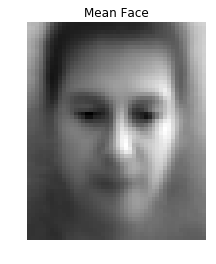

In [5]:
plt.imshow(np.reshape(pca.mean_, (46, 56)).T, cmap='gist_gray')
plt.axis('off')
plt.title('Mean Face')
plt.show()

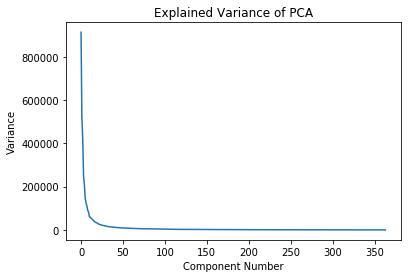

In [6]:
plt.plot(pca.explained_variance_)
plt.ylabel('Variance')
plt.xlabel('Component Number')
plt.title('Explained Variance of PCA')
plt.show()

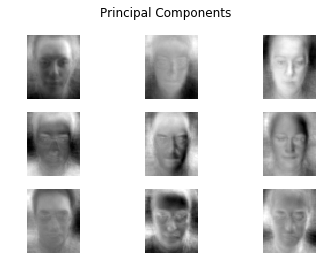

In [7]:
for i in range(0,9):
    plt.subplot(3, 3, i + 1).imshow(np.reshape(pca.components_[i, :], (46, 56)).T, cmap='gist_gray')
    plt.axis('off')

plt.suptitle('Principal Components')
plt.show()

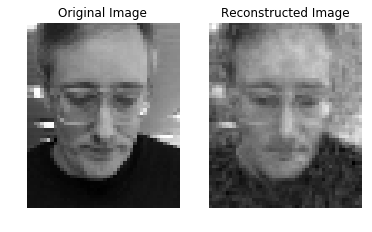

In [8]:
plt.subplot(1, 2, 1).imshow(np.reshape(face_data_test[0, :], (46,56)).T, cmap='gist_gray')
plt.title('Original Image')
plt.axis('off')

face_reconstructed = pca.inverse_transform(pca.transform(face_data_test))

plt.subplot(1, 2, 2).imshow(np.reshape(face_reconstructed[0, :], (46, 56)).T, cmap='gist_gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()

PCA recognition accuracy: 0.6217948717948718


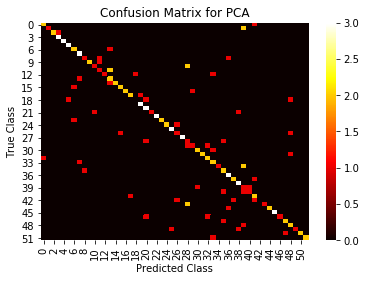

In [9]:
pca = PCA()
pca.fit(face_data_train, face_labels_train)

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(pca.transform(face_data_train), np.ravel(face_labels_train))
score_pca = neigh.score(pca.transform(face_data_test), np.ravel(face_labels_test))

print('PCA recognition accuracy:', score_pca)

cm = confusion_matrix(np.ravel(face_labels_test) , neigh.predict(pca.transform(face_data_test)), labels=range(1, 53))
sns.heatmap(cm, cmap='hot')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix for PCA')
plt.show()

LDA recognition accuracy: 0.8717948717948718


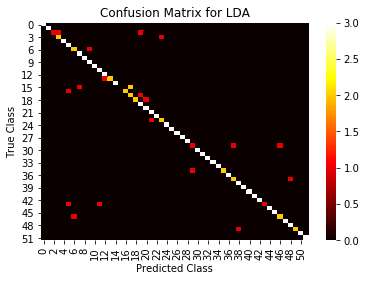

In [10]:
lda = LinearDiscriminantAnalysis()
lda.fit(face_data_train, np.ravel(face_labels_train))

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(lda.transform(face_data_train), np.ravel(face_labels_train))
score_lda = neigh.score(lda.transform(face_data_test), np.ravel(face_labels_test))

print('LDA recognition accuracy:', score_lda)

cm = confusion_matrix(np.ravel(face_labels_test) , neigh.predict(lda.transform(face_data_test)), labels=range(1,53))
sns.heatmap(cm, cmap='hot')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix for LDA')
plt.show()

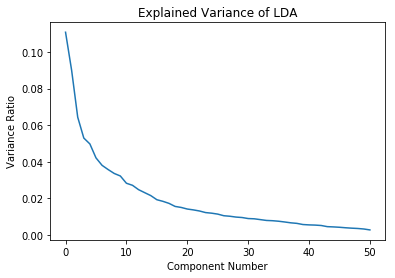

In [11]:
plt.plot(lda.explained_variance_ratio_)
plt.ylabel('Variance Ratio')
plt.xlabel('Component Number')
plt.title('Explained Variance of LDA')
plt.show()

In [ ]:
pca_lda_matrix = np.zeros((number_of_training_data - number_of_classes, number_of_classes))

for i in range(1, number_of_training_data - number_of_classes):
    for j in range(1, min(i, number_of_classes)):
        pca = PCA(n_components=i)
        pca.fit(face_data_train)

        lda = LinearDiscriminantAnalysis(n_components=j)
        lda.fit(pca.transform(face_data_train), np.ravel(face_labels_train))
        
        neigh = KNeighborsClassifier(n_neighbors=1)
        neigh.fit(lda.transform(pca.transform(face_data_train)), np.ravel(face_labels_train))
        pca_lda_matrix[i, j] = neigh.score(lda.transform(pca.transform(face_data_test)), np.ravel(face_labels_test))

np.save('pca_lda_matrix', pca_lda_matrix)

# Only run this if you have at least an hour to spare

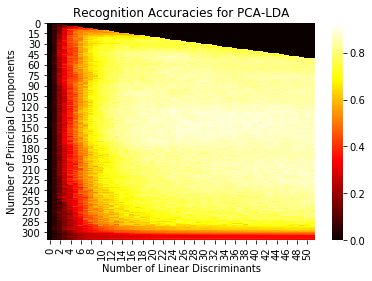

In [12]:
pca_lda_matrix = np.load('pca_lda_matrix.npy')

sns.heatmap(pca_lda_matrix, cmap='hot')
plt.ylabel('Number of Principal Components')
plt.xlabel('Number of Linear Discriminants')
plt.title('Recognition Accuracies for PCA-LDA')
plt.show()

In [13]:
pca_lda_optimum = np.ravel(np.argwhere(pca_lda_matrix == np.max(pca_lda_matrix)))

print('Best recognition accuracy for PCA-LDA:', np.max(pca_lda_matrix))
print('Number of principal components:', pca_lda_optimum[0])
print('Number of linear discriminants:', pca_lda_optimum[1])

Best recognition accuracy for PCA-LDA: 0.9294871794871795
Number of principal components: 150
Number of linear discriminants: 30


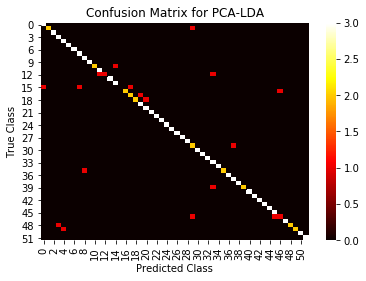

In [14]:
pca = PCA(n_components=pca_lda_optimum[0])
pca.fit(face_data_train)

lda = LinearDiscriminantAnalysis(n_components=pca_lda_optimum[1])
lda.fit(pca.transform(face_data_train), np.ravel(face_labels_train))

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(lda.transform(pca.transform(face_data_train)), np.ravel(face_labels_train))

cm = confusion_matrix(face_labels_test , neigh.predict(lda.transform(pca.transform(face_data_test))), labels=range(1,53))
sns.heatmap(cm, cmap='hot')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix for PCA-LDA')
plt.show()

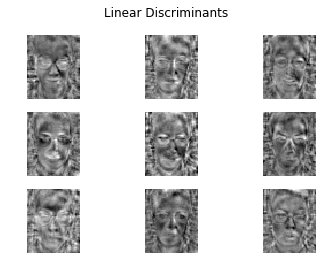

In [15]:
ld = np.dot(lda.coef_, pca.components_[:pca_lda_optimum[0], :])

for i in range(0,9):
    plt.subplot(3, 3, i + 1).imshow(np.reshape(ld[i, :], (46, 56)).T, cmap='gist_gray')
    plt.axis('off')

plt.suptitle('Linear Discriminants')
plt.show()

In [16]:
pca = PCA(n_components=pca_lda_optimum[0])
pca.fit(face_data_train)

clf = BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(n_components=pca_lda_optimum[1]), n_estimators=200)
clf.fit(pca.transform(face_data_train), np.ravel(face_labels_train))
score_ensemble = clf.score(pca.transform(face_data_test), np.ravel(face_labels_test))

print('Recognition accuracy for PCA-LDA ensemble:', score_ensemble)

# BaggingClassifier may not always beat the recognition accuracy of a single PCA-LDA model
# However, an alternative way to fuse the models may help increase the success rate
# (i.e product/sum of probability estimates or majority voting)

Recognition accuracy for PCA-LDA ensemble: 0.8974358974358975
